In [ ]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import transforms, models
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.patches as patches
import numpy as np

class StreetDetection(Dataset):
    def __init__(self, train=True, transform=None, data_path="", size=224):
        self.resize_size = size
        self.transform = transform
        print(data_path)

        self.image_paths = sorted(glob.glob(data_path + '/training/image_2/*.png'))
        self.label_paths = sorted(glob.glob(data_path + '/label/*.txt')) 


        print(self.image_paths)
        print(self.label_paths)
        # Define a mapping from class names to numerical labels
        self.class_to_idx = {"Car": 0, "Pedestrian": 1, "Cyclist": 2, "DontCare": -1}

        # Collect all bounding boxes, labels, and image references for the entire dataset
        self.bounding_boxes = []
        self._load_all_boxes()

    def _load_all_boxes(self):
        """Load all bounding boxes and labels for the entire dataset."""
        for image_idx, label_path in enumerate(self.label_paths):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_name = parts[0]
                    occlusion = parts[2]

                    # Skip bounding boxes that don't meet the criteria
                    if occlusion not in ('0', '1'):
                        continue
                    if class_name == "DontCare" or class_name not in self.class_to_idx:
                        continue

                    # Extract bounding box coordinates
                    x_min = float(parts[4])
                    y_min = float(parts[5])
                    x_max = float(parts[6])
                    y_max = float(parts[7])

                    # Skip small bounding boxes
                    if (x_max - x_min) < 32 or (y_max - y_min) < 32:
                        continue

                    # Store bounding box along with image index and label
                    label = self.class_to_idx[class_name]
                    self.bounding_boxes.append((image_idx, x_min, y_min, x_max, y_max, label))

def collate_fn(batch):
    images = [item[0] for item in batch]  # Extract images
    gt_boxes = [item[1] for item in batch]  # Extract bounding boxes
    gt_labels = [item[2] for item in batch]  # Extract labels
    
    # Stack images (batch dimension will be added)
    images = torch.stack(images, dim=0)
    
    return images, gt_boxes, gt_labels

# Define transforms for train and test
train_transform = transforms.Compose([
    transforms.Resize((int(370), int(1224))),
    transforms.ToTensor()
])



batch_size = 16
street_dataset = StreetDetection(train=True, transform=train_transform, data_path="../dataset")

# Balance the bounding boxes across classes
def balance_bounding_boxes(bounding_boxes):
    class_to_boxes = defaultdict(list)
    for item in bounding_boxes:
        _, _, _, _, _, label = item
        class_to_boxes[label].append(item)

    # Find the minimum count across all classes to balance them
    min_class_count = min(len(class_to_boxes[label]) for label in class_to_boxes if label != -1)

    balanced_boxes = []
    for label, boxes in class_to_boxes.items():
        if label == -1:
            continue
        selected_boxes = random.sample(boxes, min_class_count)
        balanced_boxes.extend(selected_boxes)

    return balanced_boxes

# Balance the bounding boxes
balanced_bounding_boxes = balance_bounding_boxes(street_dataset.bounding_boxes)

labels = [item[-1] for item in balanced_bounding_boxes]

# Split the dataset indices into train and test
train_indices, test_indices = train_test_split(
    balanced_bounding_boxes, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels  # Stratify by the class labels to ensure balance in each split
)
# Create subsets for training and testing
train_subset = torch.utils.data.Subset(street_dataset, train_indices)
test_subset = torch.utils.data.Subset(street_dataset, test_indices)

# Create data loaders for train and test sets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=3, collate_fn=collate_fn)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=3, collate_fn=collate_fn)

print(len(train_indices))
print(len(test_indices))


../dataset
['../dataset/training/image_2/000000.png', '../dataset/training/image_2/000001.png', '../dataset/training/image_2/000002.png', '../dataset/training/image_2/000003.png', '../dataset/training/image_2/000004.png', '../dataset/training/image_2/000005.png', '../dataset/training/image_2/000006.png', '../dataset/training/image_2/000007.png', '../dataset/training/image_2/000008.png', '../dataset/training/image_2/000009.png', '../dataset/training/image_2/000010.png', '../dataset/training/image_2/000011.png', '../dataset/training/image_2/000012.png', '../dataset/training/image_2/000013.png', '../dataset/training/image_2/000014.png', '../dataset/training/image_2/000015.png', '../dataset/training/image_2/000016.png', '../dataset/training/image_2/000017.png', '../dataset/training/image_2/000018.png', '../dataset/training/image_2/000019.png', '../dataset/training/image_2/000020.png', '../dataset/training/image_2/000021.png', '../dataset/training/image_2/000022.png', '../dataset/training/i

In [ ]:
print('Loaded %d training images' % len(train_subset))

Loaded 7481 training images


In [27]:
def save_cropped_images(split_boxes, dataset, output_dir, crop_size=(128, 128)):
    os.makedirs(output_dir, exist_ok=True)

    for box_idx, (image_idx, x_min, y_min, x_max, y_max, label) in enumerate(split_boxes):
        image_path = dataset.image_paths[image_idx]
        image = Image.open(image_path).convert("RGB")
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

        # Crop the bounding box from the image
        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        # Skip invalid crops
        if cropped_image.size[0] == 0 or cropped_image.size[1] == 0:
            continue

        # Resize cropped image to the specified size
        cropped_image = cropped_image.resize(crop_size)

        # Save the cropped image with a meaningful name
        label_name = [k for k, v in dataset.class_to_idx.items() if v == label][0]
        save_path = os.path.join(output_dir, f"{label_name}_{box_idx}.png")
        cropped_image.save(save_path)

# Save train and test cropped images
# save_cropped_images(train_indices, street_dataset, output_dir="../processed_crops/train", crop_size=(128, 128))
# save_cropped_images(test_indices, street_dataset, output_dir="../processed_crops/test", crop_size=(128, 128))


In [28]:
class CroppedImageDataset(Dataset):
    def __init__(self, data_path="", transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(data_path, "*.png")))
        self.class_to_idx = {"Car": 0, "Pedestrian": 1, "Cyclist": 2}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Extract the label from the filename
        label_name = os.path.basename(image_path).split('_')[0]
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.int64)

# Define transforms for the cropped images
train_transform_cropped = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32
# Initialize datasets and data loaders for the cropped images
cropped_train_dataset = CroppedImageDataset(data_path="../processed_crops/train", transform=train_transform_cropped)
cropped_test_dataset = CroppedImageDataset(data_path="../processed_crops/test", transform=train_transform_cropped)

train_loader_cropped = DataLoader(cropped_train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader_cropped = DataLoader(cropped_test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)


In [29]:
# Print class distribution for train and test cropped datasets
def print_cropped_dataset_distribution(dataset, class_to_idx):
    class_counts = defaultdict(int)
    for _, label in dataset:
        class_counts[label.item()] += 1

    for label, count in class_counts.items():
        class_name = [k for k, v in class_to_idx.items() if v == label][0]
        print(f"Class '{class_name}' has {count} samples.")

print("Train Set Class Distribution:")
print_cropped_dataset_distribution(cropped_train_dataset, street_dataset.class_to_idx)

print("\nTest Set Class Distribution:")
print_cropped_dataset_distribution(cropped_test_dataset, street_dataset.class_to_idx)

Train Set Class Distribution:
Class 'Car' has 621 samples.
Class 'Cyclist' has 620 samples.
Class 'Pedestrian' has 621 samples.

Test Set Class Distribution:
Class 'Car' has 155 samples.
Class 'Cyclist' has 156 samples.
Class 'Pedestrian' has 155 samples.


In [40]:
class MyPretrainedModel(nn.Module):
    def __init__(self, num_classes=3):
        super(MyPretrainedModel, self).__init__()
        # Load a pretrained ResNet18 model
        self.model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        # Modify the final fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    


Training on cuda


100%|██████████| 59/59 [00:05<00:00, 10.74it/s]


Train Loss: 0.2412, Train Accuracy: 90.49%
Test Loss: 0.0548, Test Accuracy: 98.50%
Best model saved with loss 0.0548


100%|██████████| 59/59 [00:05<00:00, 10.60it/s]


Train Loss: 0.0343, Train Accuracy: 99.25%
Test Loss: 0.0445, Test Accuracy: 98.28%
Best model saved with loss 0.0445


100%|██████████| 59/59 [00:05<00:00, 10.45it/s]


Train Loss: 0.0158, Train Accuracy: 99.57%
Test Loss: 0.0480, Test Accuracy: 98.50%


100%|██████████| 59/59 [00:05<00:00, 10.38it/s]


Train Loss: 0.0175, Train Accuracy: 99.46%
Test Loss: 0.0465, Test Accuracy: 98.50%


100%|██████████| 59/59 [00:05<00:00, 10.40it/s]


Train Loss: 0.0066, Train Accuracy: 99.89%
Test Loss: 0.0410, Test Accuracy: 98.71%
Best model saved with loss 0.0410


100%|██████████| 59/59 [00:05<00:00, 10.44it/s]


Train Loss: 0.0129, Train Accuracy: 99.73%
Test Loss: 0.0567, Test Accuracy: 97.64%


100%|██████████| 59/59 [00:05<00:00, 10.39it/s]


Train Loss: 0.0220, Train Accuracy: 99.25%
Test Loss: 0.1873, Test Accuracy: 95.49%


100%|██████████| 59/59 [00:05<00:00, 10.33it/s]


Train Loss: 0.0416, Train Accuracy: 98.71%
Test Loss: 0.0990, Test Accuracy: 97.00%


100%|██████████| 59/59 [00:05<00:00, 10.37it/s]


Train Loss: 0.0416, Train Accuracy: 99.03%
Test Loss: 0.0369, Test Accuracy: 98.50%
Best model saved with loss 0.0369


100%|██████████| 59/59 [00:05<00:00, 10.45it/s]


Train Loss: 0.0143, Train Accuracy: 99.62%
Test Loss: 0.0642, Test Accuracy: 97.85%


100%|██████████| 59/59 [00:05<00:00, 10.30it/s]


Train Loss: 0.0055, Train Accuracy: 99.95%
Test Loss: 0.0389, Test Accuracy: 98.50%


100%|██████████| 59/59 [00:05<00:00, 10.43it/s]


Train Loss: 0.0033, Train Accuracy: 99.95%
Test Loss: 0.0423, Test Accuracy: 98.71%


100%|██████████| 59/59 [00:05<00:00, 10.43it/s]


Train Loss: 0.0024, Train Accuracy: 99.95%
Test Loss: 0.0403, Test Accuracy: 98.71%


100%|██████████| 59/59 [00:05<00:00, 10.42it/s]


Train Loss: 0.0398, Train Accuracy: 99.19%
Test Loss: 0.0798, Test Accuracy: 97.64%
Early stopping at epoch 14. No improvement in validation loss for 5 consecutive epochs.


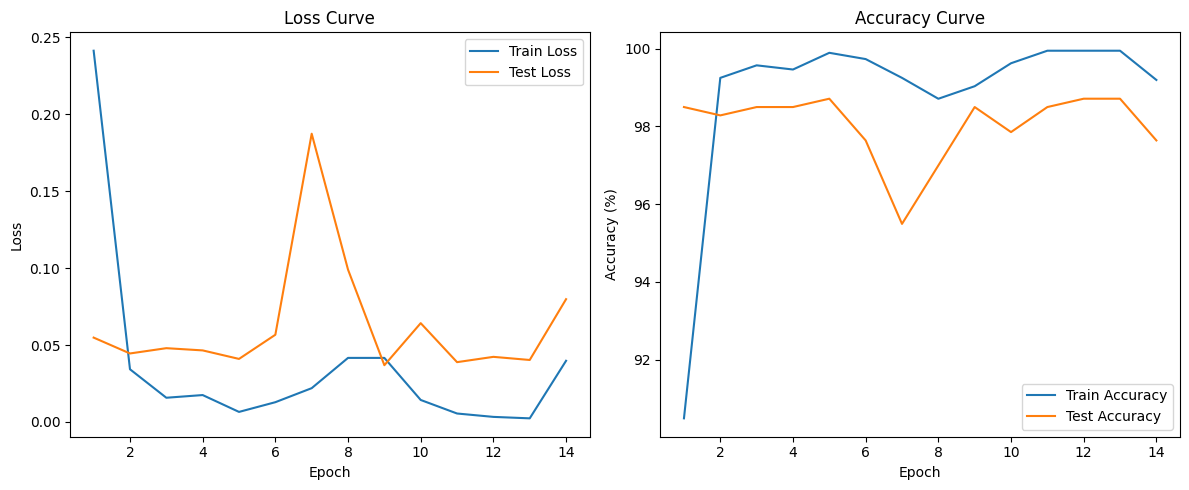

In [33]:


model = MyPretrainedModel()

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, patience=3, save_path="models/best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training on", device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_loss = float('inf')
    epochs_no_improve = 0

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        correct_test_predictions = 0
        total_test_predictions = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Compute test accuracy
                _, predicted = torch.max(outputs, 1)
                correct_test_predictions += (predicted == labels).sum().item()
                total_test_predictions += labels.size(0)

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_accuracy = correct_test_predictions / total_test_predictions * 100
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%")

        if epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with loss {best_loss:.4f}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}. No improvement in validation loss for {patience} consecutive epochs.")
            return train_losses, train_accuracies, test_losses, test_accuracies

    print("Training complete.")

    return train_losses, train_accuracies, test_losses, test_accuracies


save_path = "models/resnet_model.pth"

train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader_cropped, test_loader_cropped, num_epochs=30, learning_rate=0.0001, patience=5, save_path=save_path)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


#train_model(model, train_loader, num_epochs=10, learning_rate=0.001)


/tmp/ipykernel_5081/832963127.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/resnet_model.pth"))


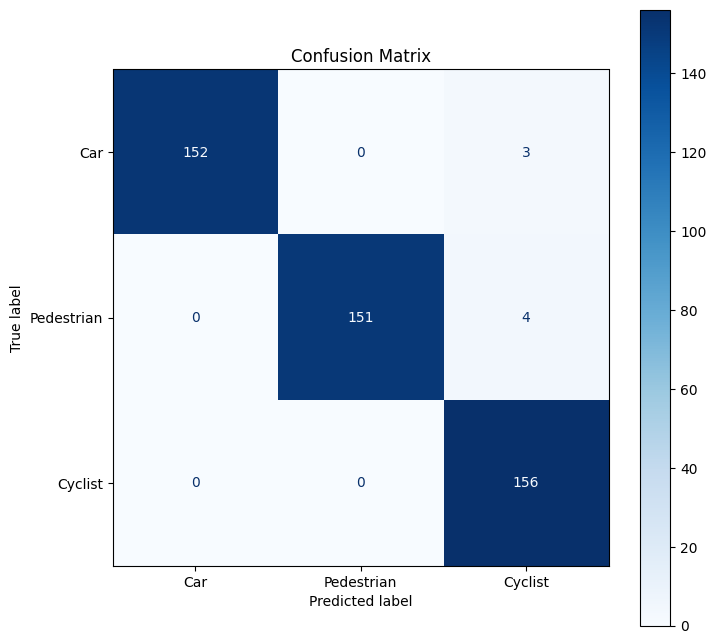

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = MyPretrainedModel()
model.load_state_dict(torch.load("models/resnet_model.pth"))

def print_confusion_matrix(model, data_loader, class_names):
    """
    Prints and plots the confusion matrix for the given model and data loader.

    Args:
    - model: Trained PyTorch model to evaluate.
    - data_loader: DataLoader providing the test dataset.
    - class_names: List of class names to label the confusion matrix axes.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming `model` is the trained model, `test_loader_cropped` is the DataLoader for the test dataset,
# and class names are ['Car', 'Pedestrian', 'Cyclist']:
class_names = ['Car', 'Pedestrian', 'Cyclist']
print_confusion_matrix(model, test_loader_cropped, class_names)


In [ ]:
model = MyPretrainedModel()
model.load_state_dict(torch.load("models/resnet_model.pth"))
# Drop the fully connected layer
model.model.fc = nn.Identity() 
dummy_input = torch.randn(1, 3, 224, 224)  # Batch of 1, with image size 224x224
features = model(dummy_input)
print("Extracted features shape:", features.shape)

Extracted features shape: torch.Size([1, 512])


/tmp/ipykernel_5081/1511407661.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/resnet_model.pth"))
